In [1]:
import math
import os
import numpy as np
import openslide
import shutil
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from openslide import OpenSlideError
import pandas as pd
# from scipy.ndimage.morphology import binary_fill_holes
# from skimage.color import rgb2gray
# from skimage.feature import canny
# from skimage.morphology import binary_closing, binary_dilation, disk

In [2]:
def open_one_slide(filename):
    try:
        slide = openslide.open_slide(filename)
    except OpenSlideError:
        slide = None
    except FileNotFoundError:
        slide = None
    return slide

def create_tile_generator(slide, tile_size, overlap):
    generator = DeepZoomGenerator(slide, tile_size=tile_size, overlap=overlap, limit_bounds=True)
    return generator


# Determine 20x Magnification Zoom Level
def get_20x_zoom_level(slide, generator):
    highest_zoom_level = generator.level_count - 1  # 0-based indexing
    # PROPERTY_NAME_OBJECTIVE_POWER:
    try:
        mag = int(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
        # `mag / 20` gives the downsampling factor between the slide's
        # magnification and the desired 20x magnification.
        # `(mag / 20) / 2` gives the zoom level offset from the highest
        # resolution level, based on a 2x downsampling factor in the
        # generator.
        offset = math.floor((mag / 20) / 2)
        level = highest_zoom_level - offset
    except (ValueError, KeyError) as e:
        # In case the slide magnification level is unknown, just
        # use the highest resolution.
        level = highest_zoom_level
    return level

def get_all_patient_slides(path):
    slide_files = []
    patient_ids = []
    for x in path.iterdir():
        if x.is_dir():
            for y in x.iterdir():
                slide_files.append(str(y))
                name = str(y).split('/')[-1]
                name = name.split('.')[0][:15]
                patient_ids.append(name)
    return slide_files, patient_ids

In [17]:
# Different function for tile extraction
def get_tiles_from_generator(generator, cols, rows):
    for col in range(cols):
        for row in range(rows):
            t = generator.get_tile(zoom, (col, row))
            tile = rgb2gray(t)
            # print(tile.shape)
            tile = 1 - tile
            # 8-bit depth complement, from 1 (dense tissue)
            # to 0 (plain background).
            tile = canny(tile)
            tile = binary_closing(tile, disk(10))
            tile = binary_dilation(tile, disk(10))
            tile = binary_fill_holes(tile)
            #print(tile)
            #plt.imshow(tile)
            #plt.show()
            percentage = tile.mean()
            if count == 100:
                break
            if percentage <= threshold:
                print()
                plt.imshow(t)
                plt.show()
                count += 1

def get_tile_from_original_slide(slide, patch_size, target_mag, save_dir, patient_id):
    if ('aperio.AppMag' not in slide.properties):
        return
    magnification = float(slide.properties['aperio.AppMag'])
    extract_patch_size = int(patch_size * magnification / target_mag)
    w, h = slide.level_dimensions[0]
    w = w // extract_patch_size * extract_patch_size
    h = h // extract_patch_size * extract_patch_size
    count = 0
    num_patch = 0
    if (save_dir/patient_id).exists():
        shutil.rmtree(save_dir/patient_id)
    (save_dir/patient_id).mkdir()
    for i in range(0, w, extract_patch_size):
        for j in range(0, h, extract_patch_size):
            patch = slide.read_region((i, j), level=0, size=[extract_patch_size, extract_patch_size])
            patch = patch.resize([patch_size, patch_size])
            patch_gray = patch.convert('1')
            ave_pixel_val = np.array(patch_gray).mean()
            if ave_pixel_val < threshold:
                num_patch += 1
                img_name = patient_id + '_' + str(count).zfill(4) + '.png'
                tile_name = save_dir/patient_id/img_name
                patch.save(str(tile_name))
            count += 1
    print(f"Number of tissue patch is {num_patch}")
    print(f"Number of total patches is {count}")


In [15]:
# some globals, can be changed to customize
target_mag = 20
threshold = 220/255
patch_size = 512
num_tiles_per_person = 200
data_dir = Path('../SVS_Raw/')
folders = [x for x in data_dir.iterdir() if x.is_dir()]
all_slides = []
all_patients = []
for folder in folders:
    curr_slide = folder.glob('*.svs')
    slide_name = str(curr_slide)
    curr_patient = slide_name.split('/')[-1][:15]
    all_patients.append(curr_patient)
    all_slides.append(slide_name)

with open('../all_patients_id.txt', 'w') as fwrite:
    for p in all_patients:
        fwrite.write(p)
        fwrite.write('\n')
        
save_dir_root = Path('../tile_data/')
if not save_dir_root.exists():
    #shutil.rmtree(save_dir_root)
    save_dir_root.mkdir()


['../slide_data/TCGA-DK-A2I6-01/TCGA-DK-A2I6-01Z-00-DX1.7BF86D3B-D4F7-47F9-B021-7FD6B673A238.svs']

In [16]:
all_patients

['TCGA-DK-A2I6-01']

In [18]:
def get_thumbnail(slide, target_mg=20):

    magnification = float(slide.properties['aperio.AppMag'])
    print(magnification)

    extract_patch_size = int(patch_size * magnification / target_mag)
    print(extract_patch_size)
    w, h = slide.level_dimensions[0]

    th_w = int(w / extract_patch_size * 10)
    th_h = int(h / extract_patch_size * 10)
    thumbnail = slide.get_thumbnail((th_w, th_h))
#     thumbnail_name = '{:s}/{:s}_thumbnail.png'.format(save_dir, slide_name)
    thumbnail.save("thumbnail_example.png")
    plt.imshow(thumbnail)
    plt.show()

In [20]:
# example = "../slide_data/TCGA-DK-A2I6-01/TCGA-DK-A2I6-01Z-00-DX1.7BF86D3B-D4F7-47F9-B021-7FD6B673A238.svs"
# slide = openslide.open_slide(str(example))
# save_dir = Path('../tile_data/')
# patient = 'TCGA-DK-A2I6-01'
for i in range(len(all_slides)):
    slide = openslide.open_slide(str(all_slides[i]))
#     get_thumbnail(slide)
    get_tile_from_original_slide(slide, patch_size, target_mag, save_dir_root, all_patients[i])

Number of tissue patch is 4997
Number of total patches is 7884


In [21]:
import glob
example = Path('../tile_data/TCGA-DK-A2I6-01/')
tiles = list(glob.glob('../tile_data/TCGA-DK-A2I6-01/*.png'))
len(tiles)

4997

In [30]:
%pwd

'/home/jupyter/preprocessing'

(512, 512)



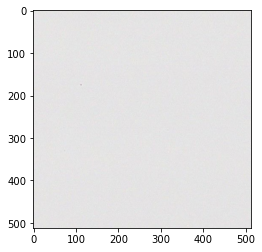

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


KeyboardInterrupt: 

In [ ]:
# This method is adapted from the lab, more steps, but results are similar
count = 0
generator = create_tile_generator(slide, 512, 0)
zoom = get_20x_zoom_level(slide, generator)
cols, rows = generator.level_tiles[zoom]
get_tiles_from_generator(generator, cols, rows)

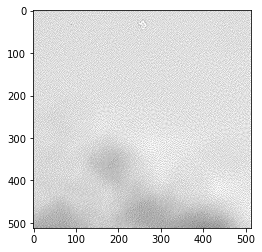

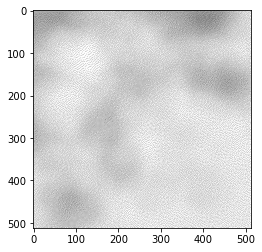

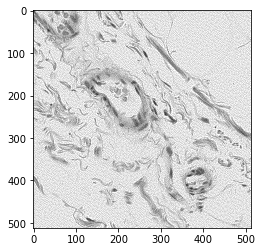

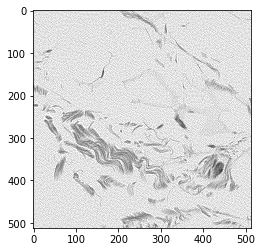

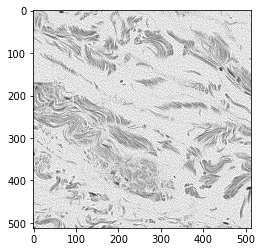

In [70]:
count = 0
